## Import Libraries

In [1]:
from os import path, makedirs
from itertools import product
import numpy as np
import scipy.io as sio

from brainpipe.system import study
from brainpipe.statistics import *

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import roc_auc_score
from numpy.random import permutation

st = study('Olfacto')
exp = 'Ret' #'Enc'
conds, subjects = ['low','high'],['VACJ','SEMC','LEFC','PIRJ','FERJ','CHAF']
freqs = ['theta','alpha','beta','gamma']
#freqs = ['raw']
#freqs = ['delta', 'theta', 'alpha', 'beta', 'low_gamma']
path_pow = path.join(st.path, 'feature/TPSim_'+exp+'_By_Odor_By_Cond/TPS_by_cond/')
#path_pow = path.join(st.path, 'feature/TPSim_Enc_Ret_By_Odor_all/TPS_R_p_by_cond/TPS_R_p_by_cond/')
filename = path.join(path_pow, 'TPS_spear_{}_cond_{}_{}_dissim.npz')
save_path = path.join(st.path, 'classified/TPSim_classif_'+exp[0]+'_by_cond_dissim/')
name_classif = path.join(save_path, '{}_LDA_classif_{}_{}_{}_dissim_MF.npz')
nperm = 1000

for su in subjects:
    for freq in freqs:
        pow_list = []
        #=========================== Load Power files (nfreq, nelec, ntrial) =================================    
        mat0 = np.load(filename.format(su,conds[0],freq[:]),allow_pickle=True)
        labels = mat0['label']
        idx = [i for i, lab in enumerate(labels) if lab !='OFC']
        #['aHC','pHC','PHG'] , ['Amg','pPirT','Ins','OFC_olf'] ['IFG','SFG','ACC','MFG']
        pow_list.append(mat0['tps'][idx,:])
        mat1 = np.load(filename.format(su,conds[1],freq[:]),allow_pickle=True)
        pow_list.append(mat1['tps'][idx,:])
        print (su,mat0.files, 'TPS shape: ', [pow.shape for pow in pow_list])
        
        #=========================== Create dict for all results =================================    
        
        if not path.exists(name_classif.format(su,freq,conds[0],conds[1])):
            kwargs = {}
            kwargs['names'], kwargs['channels'] = mat0['label'], mat0['channel']
            kwargs['xyz'] = mat0['xyz']

            # =========================== Select Power for 1 elec 1 freq =================================                 
            print('--» processing',su, ' ALL elec',nelecs, 'freq',freq)

            # create a data matrix, concatenate along the trial dimension
            x = np.concatenate(pow_list, axis=1).swapaxes(0,1)
            print ('Size of the concatenated data: ', x.shape)
            y = np.hstack([np.array([i]*x.shape[1]) for i,x in enumerate(pow_list)])
            print ('Size of label for classif: ', len(y))
            
            clf = LDA()
            cv = SKFold(5)
            auc, permut, pvalue = permutation_test_score(
            clf, x, y, scoring="roc_auc", cv=cv, n_permutations=nperm, n_jobs=-1)
            print("Classification score %s (pvalue : %s)" % (auc, pvalue))

            kwargs['perm'], kwargs['auc'] = permut, auc
            #Save plots
            np.savez(name_classif.format(su,freq,conds[0],conds[1]), **kwargs)
            del x, y, permut, auc
        else:
            print(name_classif.format(su,freq,conds[0],conds[1]), 'already computed')
    del pow_list


-> Olfacto loaded
VACJ ['tps', 'pval', 'label', 'channel', 'xyz'] TPS shape:  [(33, 66), (33, 66)]
--» processing VACJ  ALL elec 57 freq theta
Size of the concatenated data:  (132, 33)
Size of label for classif:  132
Classification score 0.8907921748581089 (pvalue : 0.000999000999000999)
VACJ ['tps', 'pval', 'label', 'channel', 'xyz'] TPS shape:  [(33, 66), (33, 66)]
--» processing VACJ  ALL elec 57 freq alpha
Size of the concatenated data:  (132, 33)
Size of label for classif:  132
Classification score 0.9028317836010145 (pvalue : 0.000999000999000999)
VACJ ['tps', 'pval', 'label', 'channel', 'xyz'] TPS shape:  [(33, 66), (33, 66)]
--» processing VACJ  ALL elec 57 freq beta
Size of the concatenated data:  (132, 33)
Size of label for classif:  132
Classification score 0.7824477720082117 (pvalue : 0.000999000999000999)
VACJ ['tps', 'pval', 'label', 'channel', 'xyz'] TPS shape:  [(33, 66), (33, 66)]
--» processing VACJ  ALL elec 57 freq gamma
Size of the concatenated data:  (132, 33)
Siz

0.7460884353741496
[0.60338722 0.8120937  0.78918626 0.76768707 0.81333726]


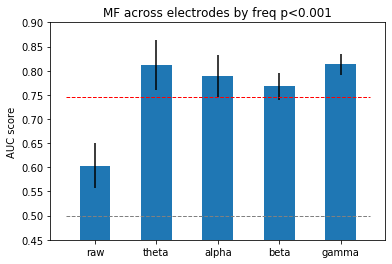

In [139]:
"""
check results for MF analysis
"""
from brainpipe.statistics import perm_pvalue2level
import matplotlib.pyplot as plt
from brainpipe.visual import addLines
from scipy.stats import sem

exp = 'R'
path_data = path.join(st.path, 'classified/TPSim_classif_'+exp+'_by_cond_dissim/')
clf_name = path.join(path_data, '{}_LDA_classif_{}_low_high_dissim_MF.npz')
path2save = path.join(st.path, 'figure/TPSim_LDA_'+exp+'_by_cond_6freqs_3s_dissim/MF/')
conds, subjects = ['low','high'],['CHAF','VACJ','SEMC','LEFC','PIRJ','FERJ']
#freqs = ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']
freqs = ['raw','theta','alpha','beta','gamma']

pval = 0.001

thr_perms = []
for su,freq in product(subjects,freqs):
    perms = np.load(clf_name.format(su,freq))['perm'][:,np.newaxis]
    thr = perm_pvalue2level(perms,maxst=True, p=pval)
    thr_perms.append(thr)
max_perm = np.max(thr_perms)
print(max_perm)

auc_all = np.array([])
for freq in freqs:
    auc_freq = np.array([])
    for su in subjects:
        auc = np.load(clf_name.format(su,freq))['auc']
        auc_freq = np.hstack((auc_freq, auc)) if np.size(auc_freq) else auc 
    auc_all = np.vstack((auc_all,auc_freq)) if np.size(auc_all) else auc_freq

mean_auc = np.mean(auc_all,axis=1)
print(mean_auc)
std_auc = sem(auc_all, axis=1)
title = 'MF across electrodes by freq p<{}'.format(pval)
plt.title(title)
plt.bar(np.arange(len(freqs)), mean_auc, width=0.5, yerr=std_auc)
addLines(plt.gca(),hLines=[0.5,max_perm], hColor=['gray','r'], 
         hWidth=[1]*2, hShape=['--']*2)
plt.ylabel('AUC score')
plt.ylim(0.45,0.9)
plt.xticks(np.arange(len(freqs)), labels=freqs)
plt.savefig(path2save+'Plot_AUC_MF_freqs_raw_all_elecs_p{}_CHAF.png'.format(pval))
plt.savefig(path2save+'Plot_AUC_MF_freqs_raw_all_elecs_p{}_CHAF.pdf'.format(pval))